# NRS SCI Data QC for WRF Comparison
__Author__: Pat McCornack

__Date__: 11/15/24

__Purpose__: Clean and check the NRS SCI data to be used in WRF model validation. 

__Notes__:


__TO DO__:
- Follow up on notes in individual sections

In [125]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Prepare Data 

In [126]:
#### Read in main dataset ####
df_original = pd.read_csv('/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/csv/NRS_SCI_met_2013-2019.csv')

# Create single datetime column
df_original['time'] = pd.to_datetime(df_original['time'])
df_original = df_original.sort_values(by='time', ascending=True)

# Subset to relevant variables
var_dict = {'time (PST)' : df_original['time'],
            'air temperature (C)' : df_original['air-temp-2-m-avg-degc'],
            'relative humidity (%)' : df_original['relative-humidity-avg-pct'],
            'wind speed (m/s)' : df_original['wind-speed-avg-ms'],
            'wind direction (deg)' : df_original['wind-direction-avg-deg'],
            'wind gust (m/s)' : df_original['wind-speed-max-ms'],
            'rain (mm)' : df_original['rainfall-mm']}

df = pd.DataFrame(var_dict)
df.set_index('time (PST)', inplace = True)
df.head()


,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain (mm)
time (PST),,,,,,
2014-01-01 00:10:00,12.65,50.53,6.031,0.425,7.609,0.0
2014-01-01 00:20:00,14.13,37.02,6.330,348.800,7.282,0.0
2014-01-01 00:30:00,13.48,40.85,5.297,359.900,6.630,0.0
2014-01-01 00:40:00,11.69,56.51,5.007,15.370,6.008,0.0
2014-01-01 00:50:00,11.47,59.24,5.159,19.630,5.816,0.0


In [127]:
#### Add attributes to dataframe #### 
#! TO DO : Get geographic information
df.attrs['Description'] = 'Nature Reserve System Santa Cruz Island Station'
df.attrs['Code'] = 'SCI'
df.attrs['Latitude'] = 33.995943
df.attrs['Longitude'] = -119.716437
#df.attrs['Elevation m'] = 

# Data QC Checks

## Summary Stats

__Things to check__:
- Nothing apparent from summary statistics

In [128]:
df.describe()

,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain (mm)
count,301153.000000,301154.000000,301154.000000,301154.000000,301154.000000,301154.000000
mean,17.069513,60.646376,3.392137,146.263856,5.262055,0.007153
std,5.566919,26.929576,2.307839,116.922792,3.553131,0.098094
min,3.062000,0.406000,0.000000,0.000000,0.000000,0.000000
25%,12.810000,39.180000,1.682000,40.680000,2.874000,0.000000
50%,16.430000,61.150000,2.788000,125.300000,4.180000,0.000000
75%,20.830000,83.800000,4.497000,247.800000,6.500000,0.000000
max,41.440000,100.000000,24.360000,360.000000,39.750000,7.874000


## Air Temperature Check

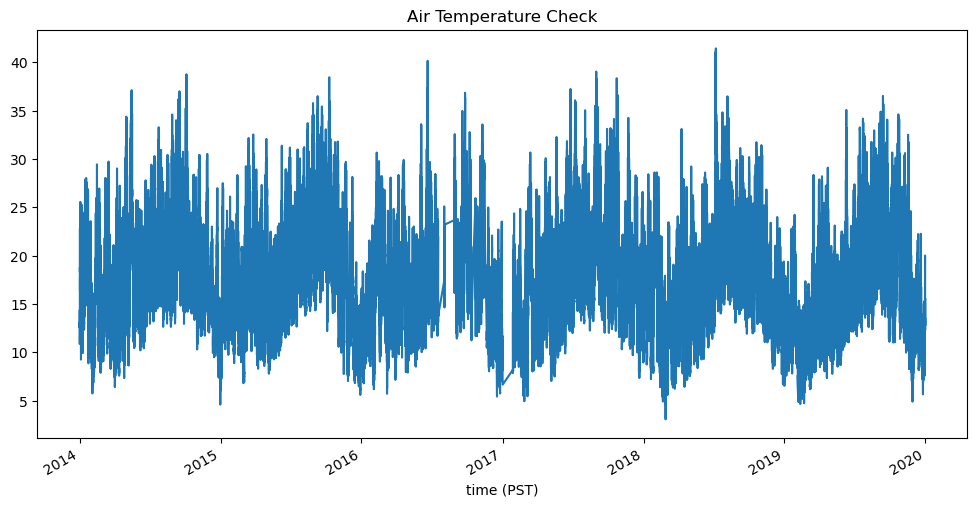

In [129]:
plt.figure(figsize=(12,6))
df['air temperature (C)'].plot()
plt.title('Air Temperature Check')
plt.show()

In [130]:
#### Find the outliers ####
df_subset = df['2005-11-17 00:00:00' : '2005-11-18 00:00:00']
air_temp_outliers = df_subset.index.tolist()
df_subset.head()

,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain (mm)
time (PST),,,,,,


In [131]:
#### Set the outliers to NaN ###
df.loc[df.index.isin(air_temp_outliers), 'air temperature (C)'] = np.nan

## RH Outlier Check
__Findings__: No apparent issues. 

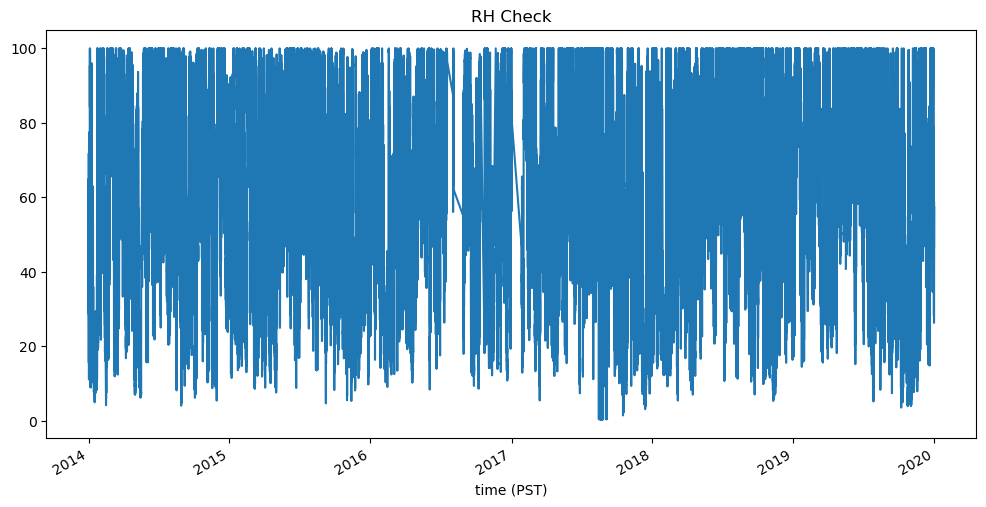

In [132]:
plt.figure(figsize=(12,6))
df['relative humidity (%)'].plot()
plt.title('RH Check')
plt.show()

## Quick Check of Wind Data

__Findings__: No apparent issues.

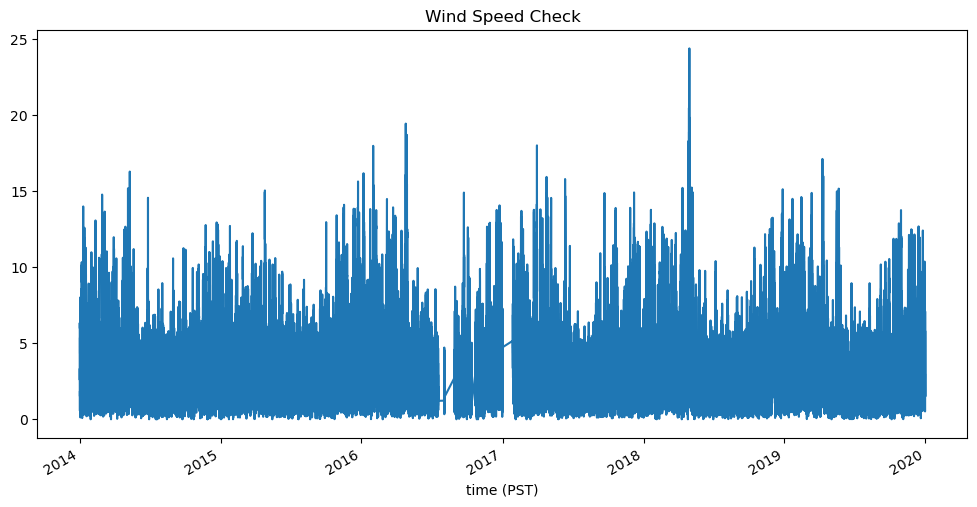

In [133]:
plt.figure(figsize=(12, 6))
df['wind speed (m/s)'].plot()
plt.title('Wind Speed Check')
plt.show()

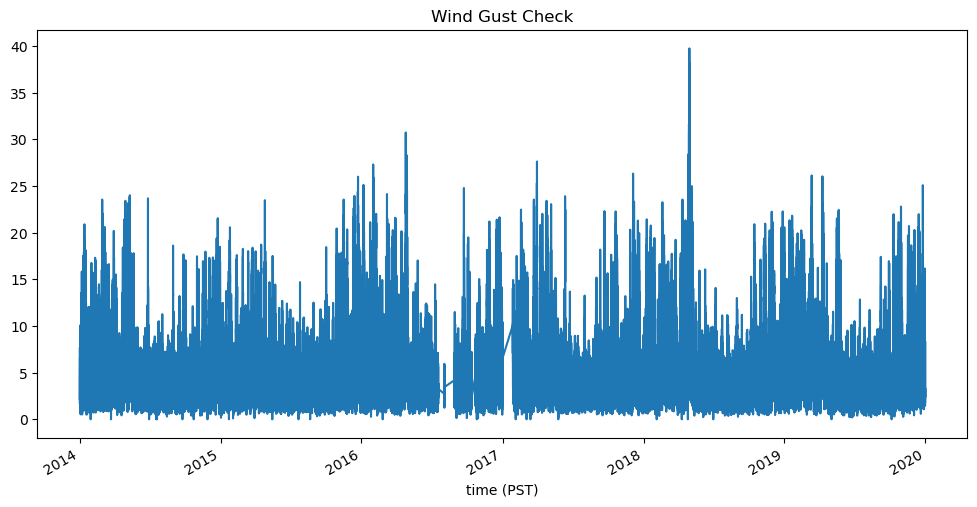

In [134]:
plt.figure(figsize=(12, 6))
df['wind gust (m/s)'].plot()
plt.title('Wind Gust Check')
plt.show()

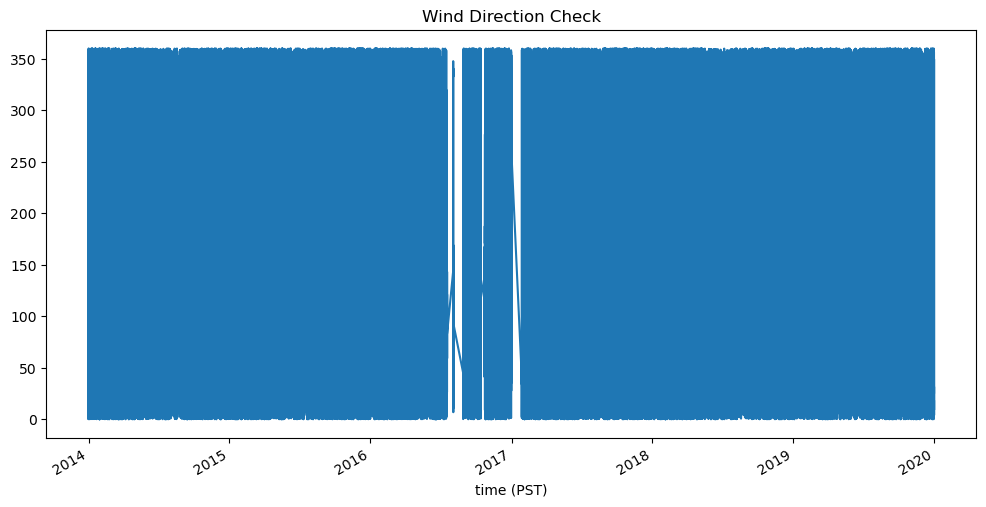

In [135]:
plt.figure(figsize=(12, 6))
df['wind direction (deg)'].plot()
plt.title('Wind Direction Check')
plt.show()

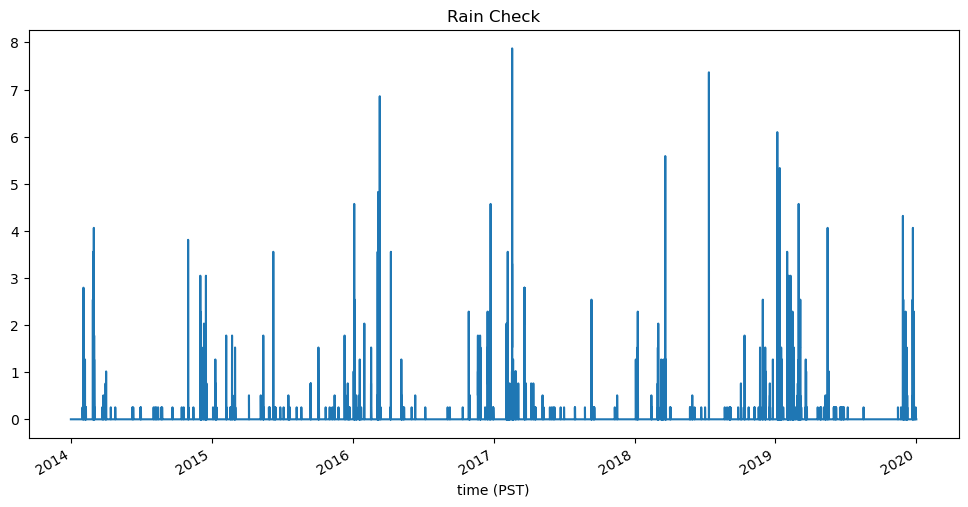

In [136]:
#### Rain Check ####
plt.figure(figsize=(12,6))
df['rain (mm)'].plot()
plt.title('Rain Check')
plt.show()

# Aggregate data

In [137]:
df_monthly = df.resample('ME').mean()
rain_mon_sum = df['rain (mm)'].resample('ME').sum()
df_monthly['rain sum (mm)'] = rain_mon_sum
df_monthly.rename(columns={'rain (mm)' : 'rain mean (mm)'}, inplace=True)


In [138]:
#### Aggregate cumsums from July-July to match WRF output ####
df_monthly['water_year'] = df_monthly.index.year + (df_monthly.index.month >= 7)
df_monthly['rain cumsum (mm)'] = df_monthly.groupby('water_year')['rain sum (mm)'].cumsum()

df_monthly.drop('water_year', axis=1, inplace=True)


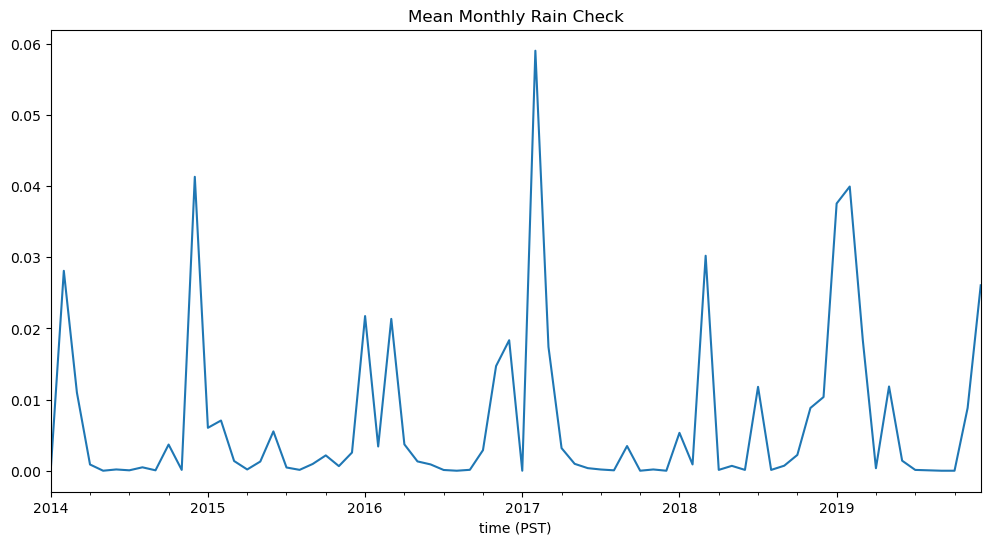

In [139]:
#### Rain Check ####
plt.figure(figsize=(12,6))
df_monthly['rain mean (mm)'].plot()
plt.title('Mean Monthly Rain Check')
plt.show()

In [141]:
df.head()

,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain (mm)
time (PST),,,,,,
2014-01-01 00:10:00,12.65,50.53,6.031,0.425,7.609,0.0
2014-01-01 00:20:00,14.13,37.02,6.330,348.800,7.282,0.0
2014-01-01 00:30:00,13.48,40.85,5.297,359.900,6.630,0.0
2014-01-01 00:40:00,11.69,56.51,5.007,15.370,6.008,0.0
2014-01-01 00:50:00,11.47,59.24,5.159,19.630,5.816,0.0


In [142]:
#### Resample data to hourly to match WRF timescale ####
sum_hourly = df[['rain (mm)']].resample('h').sum()
max_hourly = df['wind gust (m/s)'].resample('h').max()
mean_hourly = df[['air temperature (C)', 'relative humidity (%)', 'wind speed (m/s)', 'wind direction (deg)']].resample('h').mean()

df_hourly = pd.concat([sum_hourly, max_hourly, mean_hourly], axis=1)

# Save out cleaned data

## Save out resampled data


In [140]:
outdir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/csv/preprocessed'
out_file = 'NRS_SCI_monthly.csv'  # NOTE: More prep should be done (e.g. removing data) before this can actually be considered clean
df_monthly.to_csv(os.path.join(outdir, out_file))

In [143]:
outdir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/csv/preprocessed'
out_file = 'NRS_SCI_hourly.csv'  # NOTE: More prep should be done (e.g. removing data) before this can actually be considered clean
df_hourly.to_csv(os.path.join(outdir, out_file))